# Capstone project: Speed dating
## Group 4

## Task

Predict a match based on the attributes in the data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import PipelineProfiler

## Load Dataset
I used the openml library, instead of downloading the csv, because this returns the categorical_indicator

In [3]:
import openml
dataset = openml.datasets.get_dataset(40536)
X, y, categorical_indicator, _ = dataset.get_data(
  dataset_format='DataFrame',
  target=dataset.default_target_attribute
)

Cannot convert non-sparse data (<class 'pandas.core.frame.DataFrame'>) to 'DataFrame'. Returning input data.
Cannot convert non-sparse data (<class 'pandas.core.frame.DataFrame'>) to 'DataFrame'. Returning input data.


## Check distributions
The data contains many more unsuccessful matches than succesful matches. This brings the danger of the classifier to classify everything as unsuccesful.

Male/Female is fair distributed. Fairness issues can occur with race, since most people are Caucasian and other races are underrepresented in the data. 

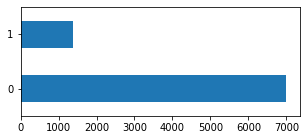

In [5]:
# Is the data balanced?
y.value_counts().plot(kind='barh', figsize=(5,2));

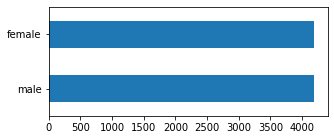

In [6]:
# See if some groups of people are more represented than others
X['gender'].value_counts().plot(kind='barh', figsize=(5,2));

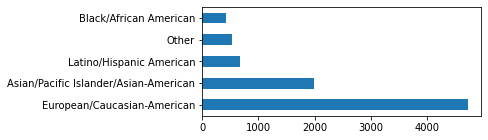

In [7]:
X['race'].value_counts().plot(kind='barh', figsize=(5,2));

## Missing values
We decided to remove the features with more than 50% missing data, since imputing on these features is not that meaningful. 

The target does not have missing values

In [8]:
X.isna().sum().sort_values(ascending = False).head(10)

# Maybe remove column with most missing values.   # DONT FORGET TO ALSO REMOVE FROM categorical_indicator

expected_num_interested_in_me    6578
expected_num_matches             1173
shared_interests_o               1076
shared_interests_partner         1067
ambitous_o                        722
ambition_partner                  712
met                               375
funny_o                           360
funny_partner                     350
guess_prob_liked                  309
dtype: int64

In [9]:
y.isna().sum()

0

## Create pipeline

Imputes missing values

Numerical values are scaled by scaler

Categorical values are one-hot-encoded

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

def flexible_pipeline(X, clf, scaler=StandardScaler()):
    """ Returns a pipeline that imputes all missing values, encodes categorical features and scales numeric ones
    Keyword arguments:
    X -- The training data
    clf -- any scikit-learn classifier
    scaler -- any scikit-learn feature scaling method (Optional)
    Returns: a scikit-learn pipeline which preprocesses the data and then runs the classifier
    """
    
    # Check what features of X are categorical 
    numeric_columns = list(X._get_numeric_data().columns)
    categorical_columns = list(set(X.columns) - set(numeric_columns))
    
    # 2 sub-pipelines, one for numeric features, other for categorical ones
    if scaler == 'None':
        numeric_pipe = make_pipeline(SimpleImputer())
    else:
        numeric_pipe = make_pipeline(SimpleImputer(),scaler)
    categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(sparse=False, handle_unknown='ignore'))

    # Using categorical pipe for features A,B,C, numeric pipe otherwise
    preprocessor = make_column_transformer((categorical_pipe, categorical_columns),
                                           (numeric_pipe, numeric_columns))

    # Combine with learning algorithm in another pipeline
    pipe = make_pipeline(preprocessor, clf)
    
    return pipe

## Test possible classifiers and scalers
Using Stratified-KFolds with 5 folds

C:\Users\s163756\AppData\Local\Continuum\anaconda3\envs\fruitpunch\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\s163756\AppData\Local\Continuum\anaconda3\envs\fruitpunch\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\s163756\AppData\Local\Continuum\anaconda3\envs\fruitpunch\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\s163756\AppData\Local\Continuum\anaconda3\envs\fruitpunch\lib\site-packages\sklearn\metrics\_ranking.py:546: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instea

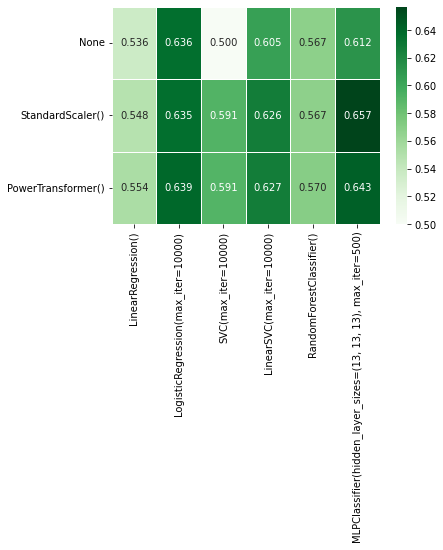

In [80]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score,accuracy_score

def plot_clfs(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        random_state=0)
    classifier = [
                LinearRegression(), 
                LogisticRegression(max_iter=10000), 
                SVC(max_iter=10000), 
                LinearSVC(max_iter=10000), 
                RandomForestClassifier(), 
                #AdaBoostClassifier(n_estimators=800), 
                MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)
              ]
    scaler = [
        'None', 
        StandardScaler(), 
        #MinMaxScaler(),
        #MaxAbsScaler(),
        PowerTransformer(),
    ]
    scores = []
    for s in scaler:
        row = []
        for c in classifier:
            pipe = flexible_pipeline(X, c, scaler=s)
            y_pred = cross_val_predict(pipe, X, y, cv=3, method='predict') #cv=StratifiedKFold(n_splits=3)
            row.append(roc_auc_score(y, y_pred))
        scores.append(row)
    df = pd.DataFrame(scores, index=scaler, columns=classifier)
    sns.heatmap(df, cmap='Greens', linewidths=0.5, annot=True, fmt=".3f")
    
plot_clfs(X,y)

## Optimize parameters

C:\Users\s163756\AppData\Local\Continuum\anaconda3\envs\fruitpunch\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\s163756\AppData\Local\Continuum\anaconda3\envs\fruitpunch\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\s163756\AppData\Local\Continuum\anaconda3\envs\fruitpunch\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\s163756\AppData\Local\Continuum\anaconda3\envs\fruitpunch\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\s163756\AppData\Local\Continuum\anaconda3\envs\fruitpunch\lib\site-packages\sklearn\linear_model\_logistic.py:1

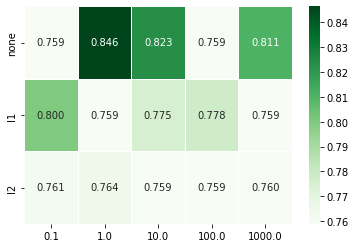

In [31]:
from sklearn.model_selection import GridSearchCV

def plot_params(X, y):
    """ Plots a heatmap for a grid search varying the C and gamma values for a scaled SVM
    """
    gamma = [1e-4, 1e-3, 1e-2, 1e-1, 1]
    C = [0.1, 1, 10, 100, 1000]
    penalty = ['none', 'l1', 'l2']
    
    #Method testing purposes, such that loading doesnt take too long
    X, _, y, _ = train_test_split(
        X, y, train_size=0.2, random_state=0)

    # Set the parameters by cross-validation
    tuned_parameters = [{
#        'logisticregression__gamma': gamma,
        'logisticregression__penalty': penalty,
        'logisticregression__C': C
    }]
    
    pipe = flexible_pipeline(X, LogisticRegression(max_iter=10000, solver='saga'), PowerTransformer())
    
    clf = GridSearchCV(
        pipe, tuned_parameters, scoring='roc_auc', cv=3
    )
    clf.fit(X, y)
    scores = np.reshape(clf.cv_results_['mean_test_score'], (-1, 5))
    # print(clf.cv_results_) #check if order is correct (yes is correct)
    
    df = pd.DataFrame(scores, index=penalty, columns=C)
    sns.heatmap(df, cmap='Greens', linewidths=0.5, annot=True, fmt=".3f")
    
plot_params(X,y)

## H2O AutoML

In [108]:
import h2o
from h2o.automl import H2OAutoML

df = X.copy()
df['target'] = y

# Start the H2O cluster (locally)
h2o.init()

frame = h2o.H2OFrame(df)

splits = frame.split_frame(ratios = [0.8], seed = 1)
train = splits[0]
test = splits[1]

# For binary classification, response should be a factor
train['target'] = train['target'].asfactor()
test['target'] = test['target'].asfactor()

aml = H2OAutoML(max_runtime_secs = 60, seed = 1)
aml.train(y = 'target', training_frame = train, leaderboard_frame = test)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------------
H2O_cluster_uptime:         1 hour 11 mins
H2O_cluster_timezone:       Europe/Berlin
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.34.0.3
H2O_cluster_version_age:    1 month and 11 days
H2O_cluster_name:           H2O_from_python_s163756_zfar7j
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    1.735 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.9.7 final
--------------------------  ---------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
20:51:16.400: AutoML: XGBoost is not available; skipping it.
20:51:16.401: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
20:51:16.401: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_2_AutoML_8_20211118_205116

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.054737781527589145
RMSE: 0.233961068401538
LogLoss: 0.19091606990261248
Null degrees of freedom: 6720
Residual degrees of freedom: 6713
Null deviance: 6017.121740846479
Residual deviance: 2566.293811630918
AIC: 2582.293811630918
AUC: 0.9728044778720878
AUCPR: 0.8971068876981058
Gini: 0.9456089557441756

Confusion Mat

0       1   Error             Rate
0      0  5340.0   273.0  0.0486   (273.0/5613.0)
1      1   168.0   940.0  0.1516   (168.0/1108.0)
2  Total  5508.0  1213.0  0.0656   (441.0/6721.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold        value    idx
0                        max f1   0.346924     0.809996  185.0
1                        max f2   0.265406     0.853967  220.0
2                  max f0point5   0.482396     0.841540  136.0
3                  max accuracy   0.443704     0.938551  149.0
4                 max precision   0.944640     1.000000    0.0
5                    max recall   0.038156     1.000000  353.0
6               max specificity   0.944640     1.000000    0.0
7              max absolute_mcc   0.346924     0.771592  185.0
8    max min_per_class_accuracy   0.267557     0.913357  219.0
9   max mean_per_class_accuracy   0.265406     0.913843  220.0
10                      max tns   0.944640  5613.000000    0.0
11                      max fns   0.944640  1104.000000    0.0
12                      max fps   0.000348  5613.000000  399.0
13                      max tps   0.038156  1108.000000  353.0
14                      max tnr   0.944640     1.000000    0.0
15                      max fnr   0.944640     0.996390    0.0
16                      max fpr   0.000348     1.000000  399.0
17                      max tpr   0.038156     1.000000  353.0


Gains/Lift Table: Avg response rate: 16.49 %, avg score: 16.59 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010118         0.844786  6.065884   
1       2                  0.020086         0.805048  6.065884   
2       3                  0.030055         0.772074  6.065884   
3       4                  0.040024         0.730481  5.884813   
4       5                  0.050141         0.697671  5.887476   
5       6                  0.100134         0.548932  5.470128   
6       7                  0.150126         0.416889  3.881444   
7       8                  0.200119         0.305393  2.310813   
8       9                  0.300104         0.177292  0.758236   
9      10                  0.400089         0.103413  0.333985   
10     11                  0.500074         0.059189  0.045133   
11     12                  0.600060         0.029448  0.027080   
12     13                  0.700045         0.013333  0.000000   
13     14                  0.800030         0.005851  0.000000   
14     15                  0.900015         0.002320  0.000000   
15     16                  1.000000         0.000111  0.000000   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          6.065884       1.000000  0.887548                  1.000000   
1          6.065884       1.000000  0.823054                  1.000000   
2          6.065884       1.000000  0.786888                  1.000000   
3          6.020785       0.970149  0.751277                  0.992565   
4          5.993886       0.970588  0.714242                  0.988131   
5          5.732396       0.901786  0.627346                  0.945022   
6          5.116023       0.639881  0.482393                  0.843409   
7          4.415242       0.380952  0.358032                  0.727881   
8          3.196844       0.125000  0.231379                  0.527020   
9          2.481396       0.055060  0.138595                  0.409074   
10         1.994288       0.007440  0.079755                  0.328771   
11         1.666501       0.004464  0.042963                  0.274733   
12         1.428480       0.000000  0.020774                  0.235494   
13         1.249954       0.000000  0.009027                  0.206063   
14         1.111093       0.000000  0.003896                  0.183171   
15         1.000000       0.000000  0.001175                  0.164856   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.887548      0.061372                 0.061372  506.588448   
1           0.855540      0.060469                 0.121841  506.588448   
2           0.832769      0.060469                 0.182310  506.588448   
3           0.812472      0.058664                 0.240975  488.481330   
4           0.792651      0.059567                 0.300542  488.747611   
5           0.710121      0.273466                 0.574007  447.012797   
6           0.634287      0.194043                 0.768051  288.144394   
7           0.565275      0.115523                 0.883574  131.081313   
8           0.454031      0.075812                 0.959386  -24.176444   
9           0.375202      0.033394                 0.992780  -66.601529   
10          0.316130      0.004513                 0.997292  -95.486693   
11          0.270613      0.002708                 1.000000  -97.292016   
12          0.234930      0.000000                 1.000000 -100.000000   
13          0.206697      0.000000                 1.000000 -100.000000   
14          0.184167      0.000000                 1.000000 -100.000000   
15          0.165871      0.000000                 1.000000 -100.000000   

    cumulative_gain  kolmogorov_smirnov  
0        506.588448            0.061372  
1        506.588448            0.121841  
2        506.588448            0.182310  
3        502.078496            0.240618  
4        499.388585            0.299829  
5        473.239603            0.567415  
6        411.602348            0.739902  
7        3



ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.09869616113461253
RMSE: 0.31415945176711224
LogLoss: 0.3165763978835324
Null degrees of freedom: 6720
Residual degrees of freedom: 6715
Null deviance: 6018.677840812963
Residual deviance: 4255.419940350443
AIC: 4267.419940350443
AUC: 0.8607110331161351
AUCPR: 0.5664525147643413
Gini: 0.7214220662322701

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29302443077388746: 


0       1   Error              Rate
0      0  4921.0   692.0  0.1233    (692.0/5613.0)
1      1   412.0   696.0  0.3718    (412.0/1108.0)
2  Total  5333.0  1388.0  0.1643   (1104.0/6721.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold        value    idx
0                        max f1   0.293024     0.557692  193.0
1                        max f2   0.131822     0.677511  283.0
2                  max f0point5   0.492840     0.565011  107.0
3                  max accuracy   0.495144     0.863562  106.0
4                 max precision   0.811547     0.918367   16.0
5                    max recall   0.001283     1.000000  397.0
6               max specificity   0.918958     0.999822    0.0
7              max absolute_mcc   0.247177     0.462891  217.0
8    max min_per_class_accuracy   0.186597     0.779441  249.0
9   max mean_per_class_accuracy   0.146747     0.784031  273.0
10                      max tns   0.918958  5612.000000    0.0
11                      max fns   0.918958  1107.000000    0.0
12                      max fps   0.000373  5613.000000  399.0
13                      max tps   0.001283  1108.000000  397.0
14                      max tnr   0.918958     0.999822    0.0
15                      max fnr   0.918958     0.999097    0.0
16                      max fpr   0.000373     1.000000  399.0
17                      max tpr   0.001283     1.000000  397.0


Gains/Lift Table: Avg response rate: 16.49 %, avg score: 16.48 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010118         0.790816  5.441455   
1       2                  0.020086         0.735020  4.617315   
2       3                  0.030055         0.687020  4.436244   
3       4                  0.040024         0.649539  3.440352   
4       5                  0.050141         0.612774  3.657372   
5       6                  0.100134         0.474021  3.339847   
6       7                  0.150126         0.378355  2.617718   
7       8                  0.200119         0.298213  2.003908   
8       9                  0.300104         0.196618  1.489391   
9      10                  0.400089         0.127663  1.047087   
10     11                  0.500074         0.079258  0.478411   
11     12                  0.600060         0.048866  0.379118   
12     13                  0.700045         0.027213  0.261772   
13     14                  0.800030         0.012907  0.117346   
14     15                  0.900015         0.004448  0.063186   
15     16                  1.000000         0.000068  0.018053   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          5.441455       0.897059  0.837283                  0.897059   
1          5.032437       0.761194  0.760342                  0.829630   
2          4.834690       0.731343  0.709601                  0.797030   
3          4.487402       0.567164  0.669010                  0.739777   
4          4.319918       0.602941  0.632190                  0.712166   
5          3.830611       0.550595  0.540510                  0.631501   
6          3.426714       0.431548  0.421789                  0.564916   
7          3.071277       0.330357  0.337064                  0.506320   
8          2.544243       0.245536  0.245666                  0.419435   
9          2.170093       0.172619  0.159339                  0.357754   
10         1.831857       0.078869  0.101213                  0.301993   
11         1.589794       0.062500  0.063210                  0.262088   
12         1.400117       0.043155  0.037448                  0.230818   
13         1.239800       0.019345  0.019522                  0.204389   
14         1.109087       0.010417  0.008207                  0.182840   
15         1.000000       0.002976  0.002024                  0.164856   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.837283      0.055054                 0.055054  444.145519   
1           0.799098      0.046029                 0.101083  361.731505   
2           0.769413      0.044224                 0.145307  343.624387   
3           0.744406      0.034296                 0.179603  244.035239   
4           0.721763      0.037004                 0.216606  265.737152   
5           0.631271      0.166968                 0.383574  233.984711   
6           0.561513      0.130866                 0.514440  161.771800   
7           0.505443      0.100181                 0.614621  100.390826   
8           0.418893      0.148917                 0.763538   48.939128   
9           0.354029      0.104693                 0.868231    4.708720   
10          0.303481      0.047834                 0.916065  -52.158947   
11          0.263445      0.037906                 0.953971  -62.088222   
12          0.231167      0.026173                 0.980144  -73.822820   
13          0.204716      0.011733                 0.991877  -88.265402   
14          0.182886      0.006318                 0.998195  -93.681370   
15          0.164802      0.001805                 1.000000  -98.194677   

    cumulative_gain  kolmogorov_smirnov  
0        444.145519            0.053807  
1        403.243749            0.096985  
2        383.469010            0.138002  
3        348.740153            0.167132  
4        331.991773            0.199325  
5        283.061055            0.339391  
6        242.671373            0.436229  
7        2

In [109]:
aml.leaderboard.head()

model_id auc logloss aucpr mean_per_class_error rmse mse 
 
 
 StackedEnsemble_AllModels_2_AutoML_8_20211118_205116 0.878768 0.300372 0.629963 0.205148 0.302209 0.0913301 
 StackedEnsemble_BestOfFamily_3_AutoML_8_20211118_205116 0.878646 0.30065 0.628611 0.20587 0.302352 0.091417 
 StackedEnsemble_AllModels_1_AutoML_8_20211118_205116 0.877353 0.30208 0.617071 0.201045 0.304141 0.0925019 
 StackedEnsemble_BestOfFamily_2_AutoML_8_20211118_205116 0.876954 0.302517 0.61398 0.203966 0.30437 0.0926413 
 StackedEnsemble_BestOfFamily_1_AutoML_8_20211118_205116 0.876733 0.302219 0.606621 0.214373 0.305459 0.0933052 
 GLM_1_AutoML_8_20211118_205116 0.871477 0.309642 0.570084 0.217327 0.309959 0.0960744 
 GBM_grid_1_AutoML_8_20211118_205116_model_1 0.865072 0.317975 0.606703 0.226618 0.31131 0.096914 
 DeepLearning_1_AutoML_8_20211118_205116 0.852725 0.340561 0.579126 0.236958 0.311903 0.0972836 
 DRF_1_AutoML_8_20211118_205116 0.852129 0.394447 0.595538 0.24776 0.313509 0.0982881 
 GBM_2_AutoML_8_20211118_205116 0.84508 0.332383 0.567096 0.249233 0.319015 0.10177

In [110]:
pred = aml.predict(test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [111]:
perf = aml.leader.model_performance(test)
perf


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.09133005553061838
RMSE: 0.3022086291465192
LogLoss: 0.30037236914850124
Null degrees of freedom: 1656
Residual degrees of freedom: 1649
Null deviance: 1479.67809754346
Residual deviance: 995.4340313581329
AIC: 1011.4340313581329
AUC: 0.8787680505415163
AUCPR: 0.6299629153326528
Gini: 0.7575361010830326

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2607660239885405: 


0      1   Error             Rate
0      0  1219.0  166.0  0.1199   (166.0/1385.0)
1      1    79.0  193.0  0.2904     (79.0/272.0)
2  Total  1298.0  359.0  0.1479   (245.0/1657.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold        value    idx
0                        max f1   0.260766     0.611727  184.0
1                        max f2   0.166247     0.701593  241.0
2                  max f0point5   0.389480     0.627133  126.0
3                  max accuracy   0.389480     0.877489  126.0
4                 max precision   0.921932     1.000000    0.0
5                    max recall   0.001266     1.000000  397.0
6               max specificity   0.921932     1.000000    0.0
7              max absolute_mcc   0.260766     0.530223  184.0
8    max min_per_class_accuracy   0.188824     0.803610  226.0
9   max mean_per_class_accuracy   0.221380     0.808445  209.0
10                      max tns   0.921932  1385.000000    0.0
11                      max fns   0.921932   271.000000    0.0
12                      max fps   0.000253  1385.000000  399.0
13                      max tps   0.001266   272.000000  397.0
14                      max tnr   0.921932     1.000000    0.0
15                      max fnr   0.921932     0.996324    0.0
16                      max fpr   0.000253     1.000000  399.0
17                      max tpr   0.001266     1.000000  397.0


Gains/Lift Table: Avg response rate: 16.42 %, avg score: 15.75 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010260         0.806990  5.733564   
1       2                  0.020519         0.722405  5.016869   
2       3                  0.030175         0.670856  4.568934   
3       4                  0.040435         0.641427  5.733564   
4       5                  0.050091         0.610386  3.426700   
5       6                  0.100181         0.464681  3.009258   
6       7                  0.150272         0.360858  3.302844   
7       8                  0.200362         0.284864  1.908310   
8       9                  0.299940         0.186781  1.550668   
9      10                  0.400121         0.115031  0.733965   
10     11                  0.500302         0.070099  0.403681   
11     12                  0.599879         0.044117  0.332286   
12     13                  0.700060         0.024257  0.146793   
13     14                  0.799638         0.009269  0.073841   
14     15                  0.899819         0.003459  0.073397   
15     16                  1.000000         0.000115  0.110095   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          5.733564       0.941176  0.846526                  0.941176   
1          5.375216       0.823529  0.762833                  0.882353   
2          5.117206       0.750000  0.695449                  0.840000   
3          5.273595       0.941176  0.655733                  0.865672   
4          4.917567       0.562500  0.626218                  0.807229   
5          3.963412       0.493976  0.536460                  0.650602   
6          3.743223       0.542169  0.409115                  0.614458   
7          3.284495       0.313253  0.322172                  0.539157   
8          2.708878       0.254545  0.229453                  0.444668   
9          2.214405       0.120482  0.147626                  0.363499   
10         1.851824       0.066265  0.090057                  0.303981   
11         1.599586       0.054545  0.056508                  0.262575   
12         1.391687       0.024096  0.033484                  0.228448   
13         1.227578       0.012121  0.016072                  0.201509   
14         1.099077       0.012048  0.005843                  0.180416   
15         1.000000       0.018072  0.001619                  0.164152   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.846526      0.058824                 0.058824  473.356401   
1           0.804679      0.051471                 0.110294  401.686851   
2           0.769726      0.044118                 0.154412  356.893382   
3           0.740802      0.058824                 0.213235  473.356401   
4           0.718714      0.033088                 0.246324  242.670037   
5           0.627587      0.150735                 0.397059  200.925762   
6           0.554763      0.165441                 0.562500  230.284373   
7           0.496615      0.095588                 0.658088   90.830971   
8           0.407919      0.154412                 0.812500   55.066845   
9           0.342748      0.073529                 0.886029  -26.603473   
10          0.292149      0.040441                 0.926471  -59.631910   
11          0.253033      0.033088                 0.959559  -66.771390   
12          0.221615      0.014706                 0.974265  -85.320695   
13          0.196019      0.007353                 0.981618  -92.615865   
14          0.174846      0.007353                 0.988971  -92.660347   
15          0.157492      0.011029                 1.000000  -88.990521   

    cumulative_gain  kolmogorov_smirnov  
0        473.356401            0.058102  
1        437.521626            0.107406  
2        411.720588            0.148636  
3        427.359526            0.206737  
4        391.756733            0.234771  
5        296.341247            0.355182  
6        274.322289            0.493186  
7        2

In [85]:
print("Accuracy: " + str(1 - 245.0/1657.0))

Accuracy: 0.852142426071213


## Auto sklearn
Cannot seem to install this package tried for 2 hours

In [28]:
import autosklearn.classification

automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=60, # sec., how long should this seed fit process run
    per_run_time_limit=15, # sec., each model may only take this long before it's killed
)

automl.fit(X_train, y_train)
y_hat = automl.predict(X_test)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_hat))

ModuleNotFoundError: No module named 'autosklearn'

## Transfer learning
TODO

## The model

In [83]:
from sklearn.metrics import confusion_matrix, accuracy_score

clf = LogisticRegression(max_iter = 10000, penalty='none', solver='saga')
scaler = PowerTransformer()
pipe = flexible_pipeline(X, clf, scaler)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.847255369928401


array([[1617,  118],
       [ 202,  158]], dtype=int64)

In [91]:
data = {'y_Actual':    y_test,
        'y_Predicted': y_pred
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])

confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted     0    1
Actual              
0          1618  117
1           202  158


## Racial bias

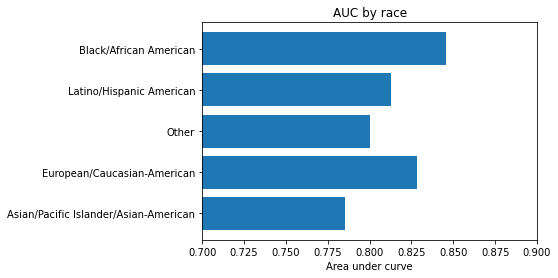

In [68]:
#Implement
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PowerTransformer

def plot_race(X, y):
    """ Returns a bar chart of the AUC measured, grouped by the value for the 'race' feature
    """
    pipe = flexible_pipeline(X, LogisticRegression(max_iter = 10000, C = 0.1, penalty='l2'), PowerTransformer())
    proba = cross_val_predict(pipe, X, y, cv=StratifiedKFold(n_splits=3), method='predict_proba')[:,1]
    
    # Get indices of rows by race
    race_idx = []
    labels = []
    for race in X['race'].cat.categories:
        race_idx.append(X['race']==race)
        labels.append(race)
        
    # Get y_true and y_pred by race, and AUC score
    y_true = []
    y_pred = []
    scores = []
    for race in range(len(race_idx)):
        y_true.append(y[race_idx[race]])
        y_pred.append(proba[race_idx[race]])
        scores.append(roc_auc_score(y_true[race], y_pred[race]))
        
    x = np.arange(len(labels)) 
    fig, ax = plt.subplots()
    ax.barh(x, scores)
    ax.set_xlabel('Area under curve')
    ax.set_title('AUC by race')
    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    ax.set_xlim([0.7, 0.9])
    
plot_race(X, y)

In [43]:
# Helper function to get feature names
# Source:
# https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html 

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [86]:
# Plotting function. Do not edit.
def plot_importances(importance, feature_names, top_k=20, title=""):
    """ Simple bar chart plottinh feature importances
    Keyword arguments:
    importance -- The feature importances 
    feature_names -- The original features names in their original order
    top_k -- How many features to plot
    """
    # Trees
    sorted_idx = importance.argsort()[-top_k:]
    fig, ax = plt.subplots(figsize=(8, 8))
    y_ticks = np.arange(0, top_k)
    ax.barh(y_ticks, importance[sorted_idx])
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title(title)

    fig.tight_layout()
    plt.show()

C:\Users\s163756\AppData\Local\Continuum\anaconda3\envs\fruitpunch\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\s163756\AppData\Local\Temp/ipykernel_22864/2635971155.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


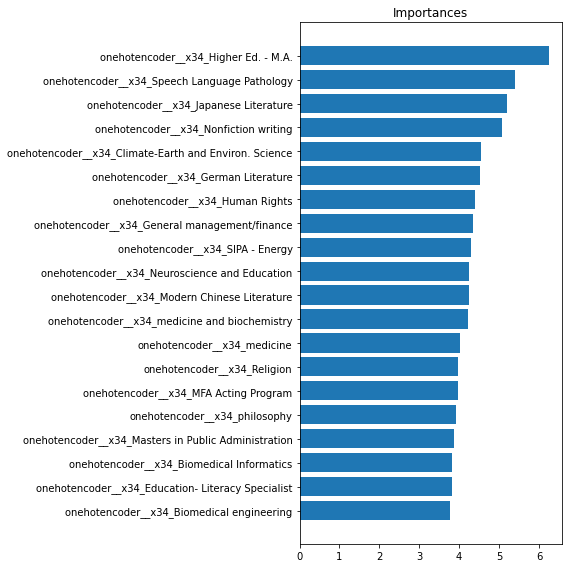

In [87]:
from fairlearn.metrics import (
    MetricFrame,
    false_positive_rate,
    true_positive_rate,
    selection_rate,
    count,
)
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = flexible_pipeline(X, LogisticRegression(max_iter = 10000, penalty='none'), PowerTransformer()).fit(X_train, y_train)

y_true =  y_test
y_pred = pipe.predict(X_test)
y_true = y_true.astype(int)
y_pred = y_pred.astype(int)


importances = pipe['logisticregression'].coef_[0]
#indices = np.argsort(importances)[::-1]
feature_names = get_feature_names(pipe['columntransformer'])
plot_importances(np.array(importances), np.array(feature_names), top_k=20, title="Importances", )

C:\Users\s163756\AppData\Local\Temp/ipykernel_22864/2635971155.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


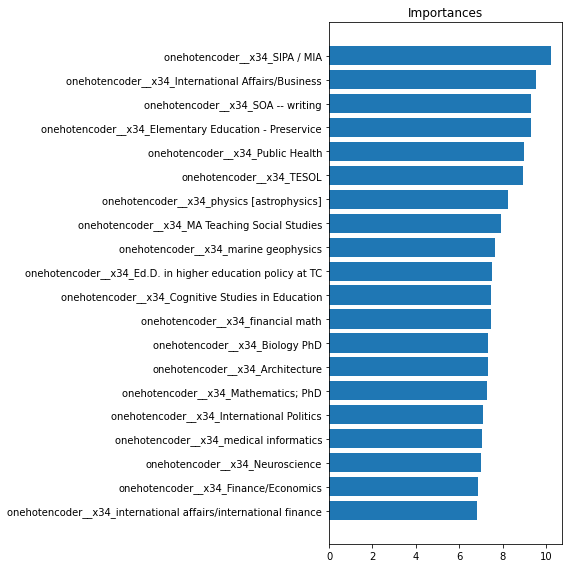

In [88]:
importances = pipe['logisticregression'].coef_[0] * -1
#indices = np.argsort(importances)[::-1]
feature_names = get_feature_names(pipe['columntransformer'])
plot_importances(np.array(importances), np.array(feature_names), top_k=20, title="Importances", )

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='gender'>],
       [<AxesSubplot:title={'center':'false positive rate'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'true positive rate'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='gender'>],
       [<AxesSubplot:title={'center':'count'}, xlabel='gender'>,
        <AxesSubplot:xlabel='gender'>, <AxesSubplot:xlabel='gender'>]],
      dtype=object)

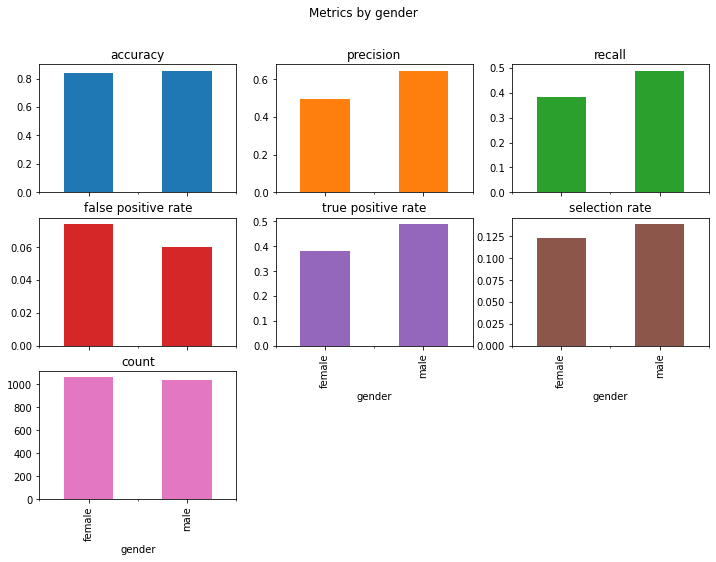

In [89]:

race = X_test['race']
sex = X_test['gender']

# Analyze metrics using MetricFrame
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "false positive rate": false_positive_rate,
    "true positive rate": true_positive_rate,
    "selection rate": selection_rate,
    "count": count,
}
mf = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sex
)

# Customize plots with ylim
mf.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metrics by gender",
)

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='race'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='race'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='race'>],
       [<AxesSubplot:title={'center':'false positive rate'}, xlabel='race'>,
        <AxesSubplot:title={'center':'true positive rate'}, xlabel='race'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='race'>],
       [<AxesSubplot:title={'center':'count'}, xlabel='race'>,
        <AxesSubplot:xlabel='race'>, <AxesSubplot:xlabel='race'>]],
      dtype=object)

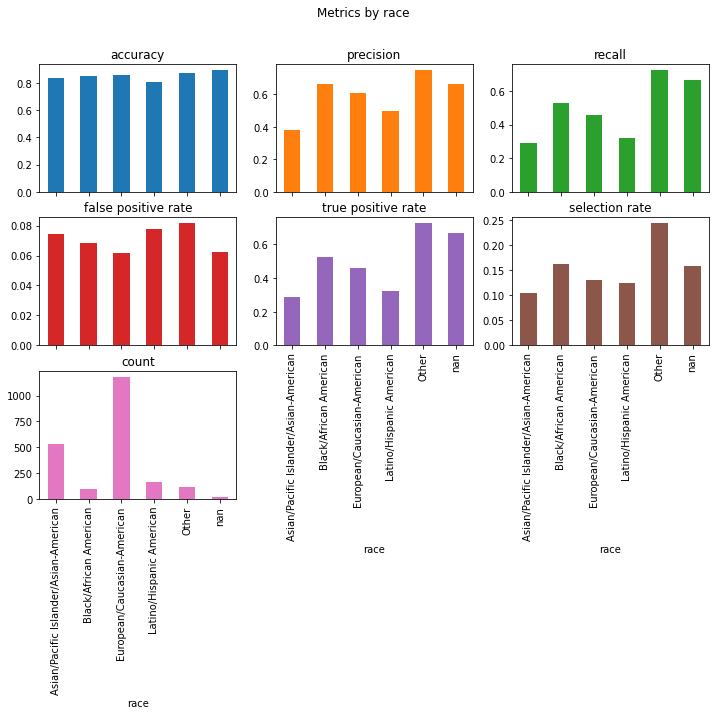

In [90]:
mf = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=race
)

# Customize plots with ylim
mf.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metrics by race",
)